# Racecar Problem
Consider driving a race car in a race track as shown in the excel sheet . The car will always be at any one of the
discrete grid positions shown in the sheet. The green grids 1,2, 3 marks any of the starting positions . The orange
grids a,b,c,d,e marks any of the ending positions. The blue grid represent valid positions the car can take. The red
grids represents the boundaries. The velocity is discrete and is the number of grid cells moved horizontally and
vertically per time step. The actions are increments to velocity components. The horizontal and vertical components
may be changed by -1, 0 or 1 during a time step. Thus the actions are selected from a total of 3x3 possible actions.
Both velocity components follow the following constraints

- 0 ≤ 𝑣𝑥 ≤ 5 ; 0 ≤ 𝑣𝑦 ≤ 5 (Clip the velocity in case it crosses boundaries)
- 𝑣𝑥 and 𝑣𝑦 cannot both be zero except at the start line.

Each episode begins at randomly selected start lines and ends when the car reaches any of the states in finish line.
The rewards are -1 for each time step until the car crosses the finish line. If the car intersects any of the red boundary
grids, the car will be reset randomly to any of the starting positions in green. Both the velocity components will be
reduced to zero and the episode continues. (Before updating car’s location check to see if car intersects finish line or
boundary). If car intersects orange finish line, episode ends. If the car intersects red boundary, it will get reset.

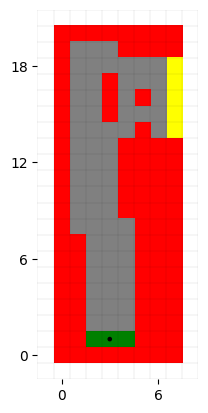

## Installing and Importing Required Modules

In [116]:
! pip install numpy
! pip install gym
! pip install matplotlib
! pip install --pre scikit-image
! pip install seaborn

In [117]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import skimage.draw
import matplotlib
# Visualisation used from:-
# https://github.com/vojtamolda/reinforcement-learning-an-introduction/tree/main/chapter05/racetrack
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Making Environment
render() used from https://github.com/vojtamolda/reinforcement-learning-an-introduction/tree/main/chapter05

In [118]:
class RaceTrack(gym.Env):
    # defining action_space for gym
    action_space = gym.spaces.MultiDiscrete([3,3])

    def __init__(self) -> None:
        # Defining the racetrack
        self.racetrack = [
            [0,0,0,0,0,0,0,0],
            [0,1,1,1,0,0,0,0],
            [0,1,1,1,1,1,1,2],
            [0,1,1,0,1,1,1,2],
            [0,1,1,0,1,0,1,2],
            [0,1,1,0,1,1,1,2],
            [0,1,1,1,1,0,1,2],
            [0,1,1,1,0,0,0,0],
            [0,1,1,1,0,0,0,0],
            [0,1,1,1,0,0,0,0],
            [0,1,1,1,0,0,0,0],
            [0,1,1,1,0,0,0,0],
            [0,1,1,1,1,0,0,0],
            [0,0,1,1,1,0,0,0],
            [0,0,1,1,1,0,0,0],
            [0,0,1,1,1,0,0,0],
            [0,0,1,1,1,0,0,0],
            [0,0,1,1,1,0,0,0],
            [0,0,1,1,1,0,0,0],
            [0,0,3,3,3,0,0,0],
            [0,0,0,0,0,0,0,0]
        ]

        self.racetrack = np.array(self.racetrack).T
        self.racetrack = np.fliplr(self.racetrack)

        # Defining action space for gym
        self.observation_space = gym.spaces.MultiDiscrete([*self.racetrack.shape,6,6])
        self.state = None
        self.plt = None

    def collisionVal(self,pos,nextPos):
        # Calculate all intersection points by making a line
        # skimage is a line that draws a line between 2 points 
        # and give all x and y it intersect 
        # reference:- https://stackoverflow.com/questions/58635782/how-to-draw-shapes-ellipses-rectange-circle-etc-with-line-width-thicker-tha
        x,y = skimage.draw.line(*(pos),*nextPos)
        x1 = np.clip(x,0,7)
        y1 = np.clip(y,0,20)
        val = self.racetrack[x1,y1]

        # Checking if car is on track, wall or finish line
        inTrack = (x == x1).all() and (y == y1).all()
        finishCrossed = (val == 2).any()
        wall = (val == 0).any()

        return inTrack,finishCrossed,wall
    
    # reset the state
    def reset(self, hardReset = True):
        if(self.plt is not None):
            reset = np.copy(self.state)
            self.render()

        starts = np.where(self.racetrack == 3)
        index = np.random.randint(starts[0].size)
        self.state = np.array([starts[0][index],starts[1][index],0,0])

        self.plt = None if hardReset else self.plt
        if self.plt is not None:
            self.render(reset=reset)

        return self.state
    
    def render(self,reset = None):
        if self.plt is None:
            fig = plt.figure()
            self.plt = fig.gca()

            # Racetrack background 
            cmap = mcolors.ListedColormap(["red","gray","yellow","green"])
            self.plt.imshow(self.racetrack.T,aspect='equal',origin="lower",cmap=cmap)

            self.plt.set_xticks(np.arange(0,8,5),minor=False)
            self.plt.set_yticks(np.arange(0,21,5),minor = False)

            margin = 1
            self.plt.set_xticks(np.arange(-0.5 - margin, 8 + margin, 1), minor = True)
            self.plt.set_xticks(np.arange(-0.5 - margin, 21 + margin, 1), minor = True)
            self.plt.grid(which="minor", color = "black", linewidth = 0.05)
            self.plt.tick_params(which = "minor", length = 0)
            self.plt.set_frame_on(False)

        pos = self.state[:2]
        vel = self.state[2:]

        if reset is not None:
            resetPos = reset[:2]
            patch = mpatches.FancyArrow(*resetPos,*(pos - resetPos),color="blue",
                                        fill=False,width=0.1, head_width=0.25,length_includes_head=True)
            
        else:
            patch = mpatches.FancyArrow(*(pos - vel),*vel,color="black",
                                        zorder=2, fill=True,width=0.05,head_width=0.25,length_includes_head=True)
            
        self.plt.add_patch(patch)
        return self.plt

    def step(self,action):
        # print(action)
        pos = self.state[:2]
        vel = self.state[2:]

        # Calculating Acceleration and checking if it is valid
        if(np.random.rand() < 0.1):
            acc = np.array([0,0])

        else:
            acc = action - 1
        assert (-1 <= acc).all() and (acc <= 1).all()

        # Calculate speed
        vel += acc
        # print(vel)

        # Clip Velocity
        vel = np.clip(vel,0,5)
        if (vel > 0).any():
            pass
        else:
            vel = np.array([0,1])

        assert (0 < vel).any() and (vel < 6).all()
        # print(vel)

        # Calculate Position
        nextPos = pos + vel
        inTrack,finish,wall = self.collisionVal(pos,nextPos)
        pos = nextPos

        # Checking if we hit wall or not in track
        if wall or (not finish and not inTrack):
            self.state = np.hstack([pos,vel])
            self.reset(hardReset = False)
            return self.state,-1,False,{}
        
        clipped = np.clip(pos,0,np.array([8,21]) - 1)
        vel -= pos - clipped
        pos = clipped
        assert (0 <= pos).all() and (pos <= self.racetrack.shape).all()

        self.state = np.hstack([pos,vel])
        return self.state, -1, finish, {}
    

gym.envs.registration.register(
    id = "RaceTrack",
    entry_point = lambda : RaceTrack(),
    nondeterministic=True,
    kwargs={}
)  

## Generate the Episode

In [208]:
def episode(env,policy,render = False):
    actionPossible_idxs = np.arange(np.int32(np.prod(env.action_space.nvec)))
    states = []
    actions = []
    rewards = []

    done = False
    state = env.reset()
    if(render):
        env.render()
    x = 0
    while (not done):
        s = np.ravel_multi_index(state,env.observation_space.nvec)
        states = states + [s]

        idx = np.random.choice(actionPossible_idxs,p = policy[s])
        action = np.array(np.unravel_index(idx,env.action_space.nvec))
        actions = actions + [idx]

        state, reward, done,_ = env.step(action)
        rewards = rewards + [reward]

        if render:
            env.render()

    returns = np.cumsum(rewards[::-1])[::-1]
    assert (len(states) == len(actions) == len(returns))

    return states,actions,returns

In [120]:
# Taken from github
matplotlib.rcParams['figure.figsize'] = [10, 10]

def plot_results(env, q, policy):
    v = np.max(q, axis=1).reshape(env.observation_space.nvec)
    v_pos = np.mean(v, axis=(2, 3))        
    
    unvisited_filter = np.where(v_pos == 1.0)
    v_pos[unvisited_filter] = np.nan
    
    plt.figure()
    plt.title("Value Function Averaged over Speeds")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.imshow(v_pos.T, origin='lower')
    plt.colorbar()
    
    a_star_ridxs = np.argmax(policy, axis=1).reshape(env.observation_space.nvec)
    a_stars = np.array(np.unravel_index(a_star_ridxs, env.action_space.nvec)) - 1
    a_stars_mean = np.mean(a_stars, axis=(-1, -2))
    a_stars_norm = (a_stars_mean.T - np.mean(a_stars_mean, axis=(1, 2))).T
    a_stars_norm[:, unvisited_filter[0], unvisited_filter[1]] = 0
    
    env.reset()
    axis = env.render()
    xs, ys = np.arange(env.observation_space.nvec[0]), np.arange(env.observation_space.nvec[1])
    a_star_x, a_star_y = a_stars_norm[0], a_stars_norm[1]
    axis.quiver(xs, ys, a_star_x.T, a_star_y.T)
    
    plt.title("Action Averaged Over Speeds")
    plt.xlabel("X")
    plt.ylabel("Y")

## ON POLICY MONTE CARLO CONTROL


In [ ]:
def onPolicy(env,num_episodes,eps = 0.1, alpha = 0.05):
    numberOfStates = 21 * 8 * 6 * 6
    numberOfActions = 3 * 3
    x = []
    Qs = []
    q = np.ones([numberOfStates,numberOfActions],dtype=np.float64)
    pi = np.ones([numberOfStates,numberOfActions],dtype=np.float64)/numberOfActions

    for i in range(num_episodes):
        states,actions,returns = episode(env,pi)

        for state,action,g in zip(states,actions,returns):
            q[state,action] += alpha * (g - q[state,action])

        # Greedy action for each state
        greedyAction = np.argmax(q[states,:],axis= 1)
        nPi = np.copy(pi)
        pi[states,:] = eps/numberOfActions
        pi[states,greedyAction] = 1 - eps + eps/numberOfActions
        Qs.append(np.sum(nPi - pi))
        
        assert np.allclose(np.sum(pi,axis=1),1)
        x.append([min(returns),len(states)])
        if(i % 10000 == 0):
            print("Episode Number :- " + str(i) + " Min Return = " + str(min(returns)) + " states used:- " + str(len(states)))
            

    tr = np.copy(pi)
    
    greedyAction = np.argmax(q,axis=1)
    pi[:,:] = 0
    pi[np.arange(numberOfStates),greedyAction] = 1
    assert np.allclose(np.sum(pi,axis=1),1)
    return q,pi,x,tr,Qs


In [212]:
env = gym.make("RaceTrack")
q,pi,x,tr,Qs = onPolicy(env,100000,eps=0.1,alpha=0.1)

Episode Number :- 0 Min Return = -136 states used:- 136
Episode Number :- 10000 Min Return = -10 states used:- 10
Episode Number :- 20000 Min Return = -13 states used:- 13
Episode Number :- 30000 Min Return = -22 states used:- 22
Episode Number :- 40000 Min Return = -13 states used:- 13
Episode Number :- 50000 Min Return = -111 states used:- 111
Episode Number :- 60000 Min Return = -13 states used:- 13
Episode Number :- 70000 Min Return = -17 states used:- 17
Episode Number :- 80000 Min Return = -12 states used:- 12
Episode Number :- 90000 Min Return = -31 states used:- 31


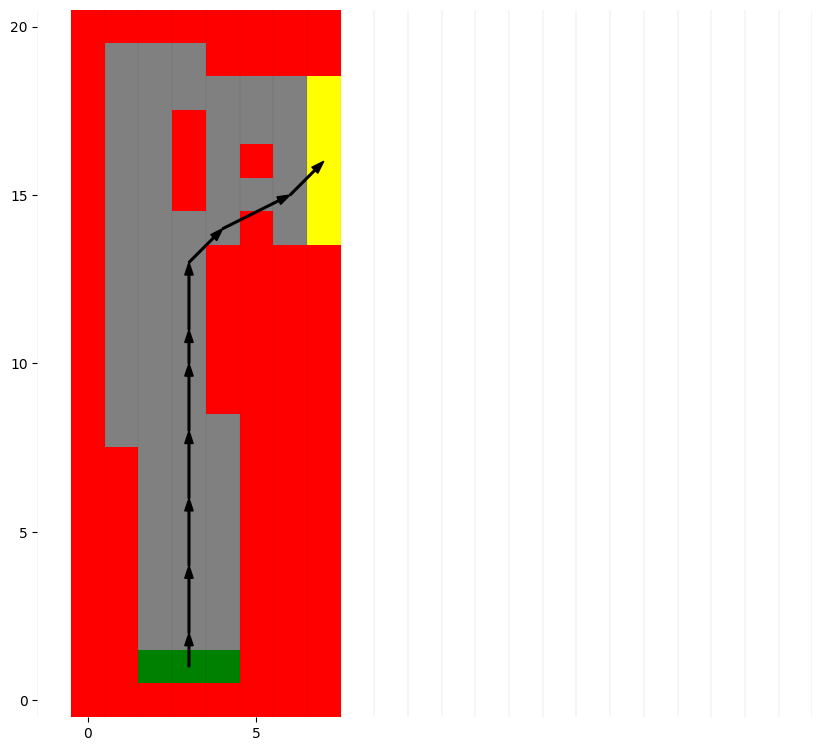

In [127]:
vals = episode(env,policy=pi,render=True)

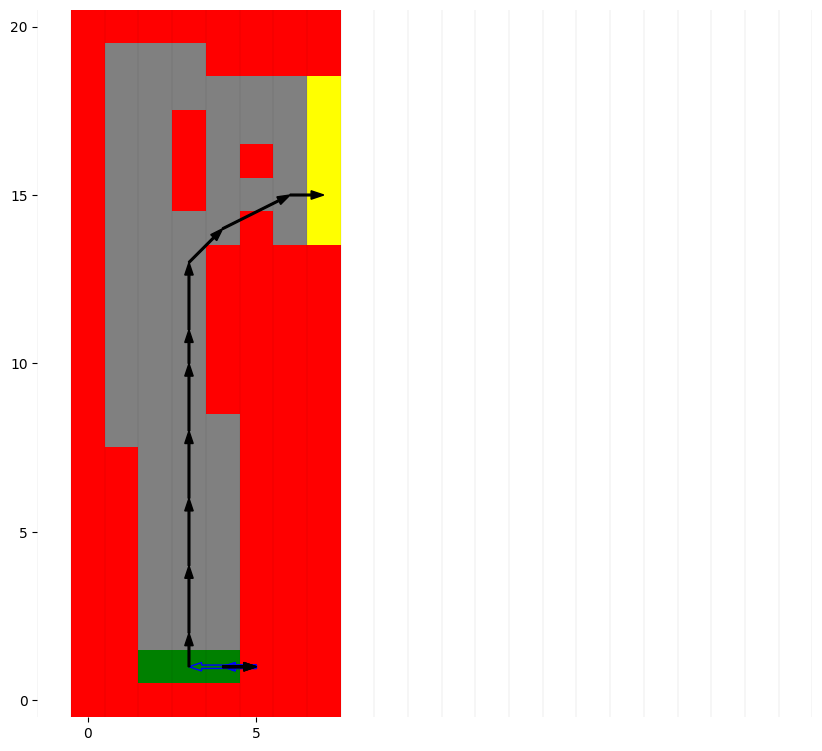

In [134]:
vals = episode(policy=pi,env=env,render=True)

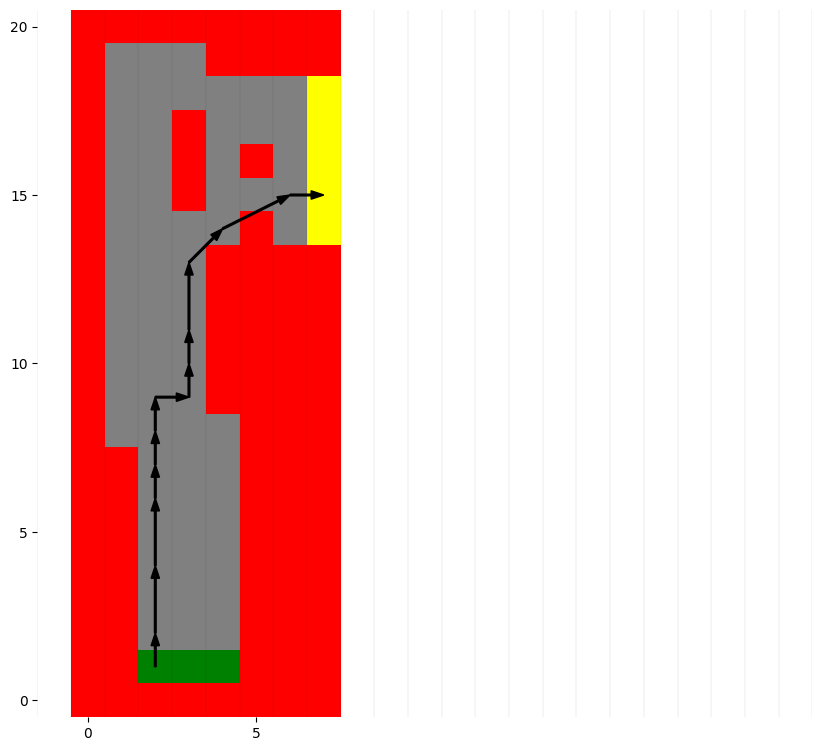

In [135]:
vals = episode(policy=pi,env=env,render=True)

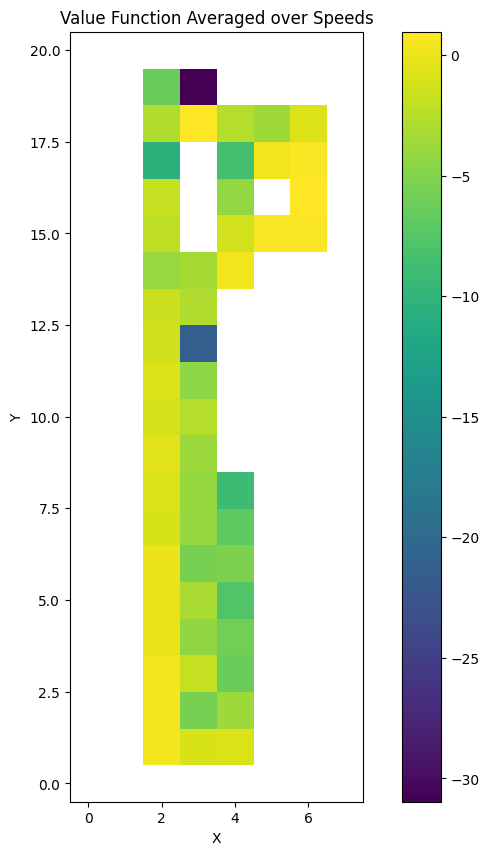

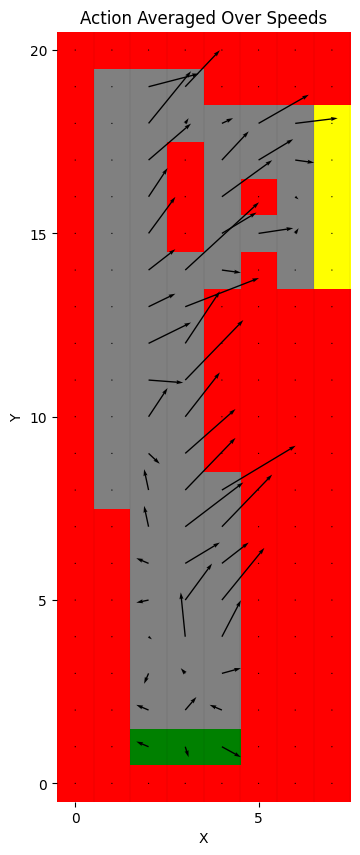

In [140]:
plot_results(env,q,pi)

## OFF POLICY MONTE CARLO CONTROL

In [219]:
def offPolicy(env,num_iteration,targetPolicy,alpha):
    n_states = 21*8*6*6
    n_actions = 3*3
    Qs = []
    q = np.ones((n_states,n_actions),dtype=np.float64)
    c = np.zeros((n_states,n_actions),dtype=np.float64)
    pi = np.ones((n_states,n_actions),dtype=np.float64)/n_actions

    c = np.zeros((n_states,n_actions),dtype=np.float64)
    x = []
    for i in range(num_iteration):
        states,actions,returns = episode(env,targetPolicy)
        W = 1
        nPi = np.copy(pi)
        for state,action,g in zip(states,actions,returns):
            c[state,action] = c[state,action] + W
            q[state,action] += alpha * (g - q[state,action])/(W/c[state,action])
            greedy = np.argmax(q[state])
            pi[state,:] = 0
            pi[state,greedy] = 1
            
            if(action != greedy):
                break

            W /= targetPolicy[state,action]
        Qs.append(np.sum(nPi - pi))  
        if(i % 10000 == 0):
            print("Episode Number :- " + str(i) + " Min Return = " + str(min(returns)) + " states used:- " + str(len(states)))
        x.append([min(returns),len(states)])

    return pi,q,x,Qs

In [220]:
pi1,q1,x1,Qs1 = offPolicy(env,100000,tr,0.1)

Episode Number :- 0 Min Return = -23 states used:- 23
Episode Number :- 10000 Min Return = -38 states used:- 38
Episode Number :- 20000 Min Return = -13 states used:- 13
Episode Number :- 30000 Min Return = -13 states used:- 13
Episode Number :- 40000 Min Return = -40 states used:- 40
Episode Number :- 50000 Min Return = -25 states used:- 25
Episode Number :- 60000 Min Return = -8 states used:- 8
Episode Number :- 70000 Min Return = -24 states used:- 24
Episode Number :- 80000 Min Return = -13 states used:- 13
Episode Number :- 90000 Min Return = -14 states used:- 14


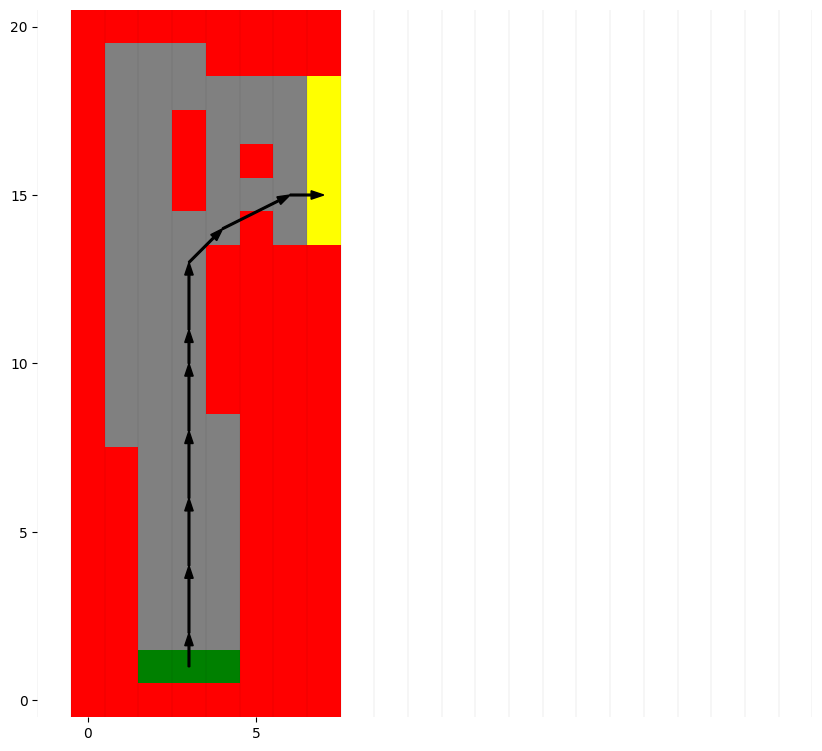

In [ ]:
vals = episode(policy=pi1,env=env,render=True)

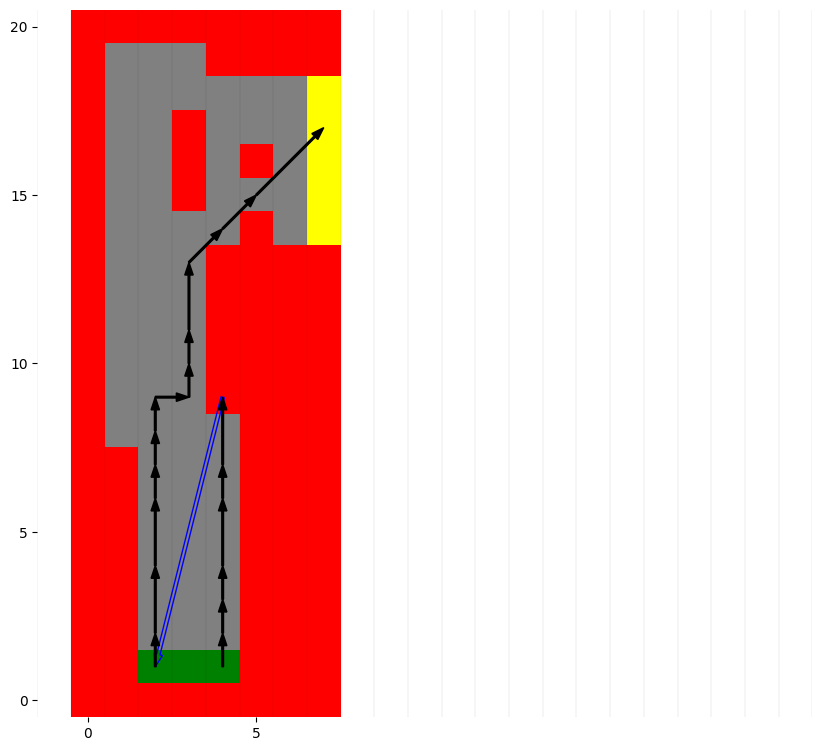

In [ ]:
vals = episode(policy=pi1,env=env,render=True)

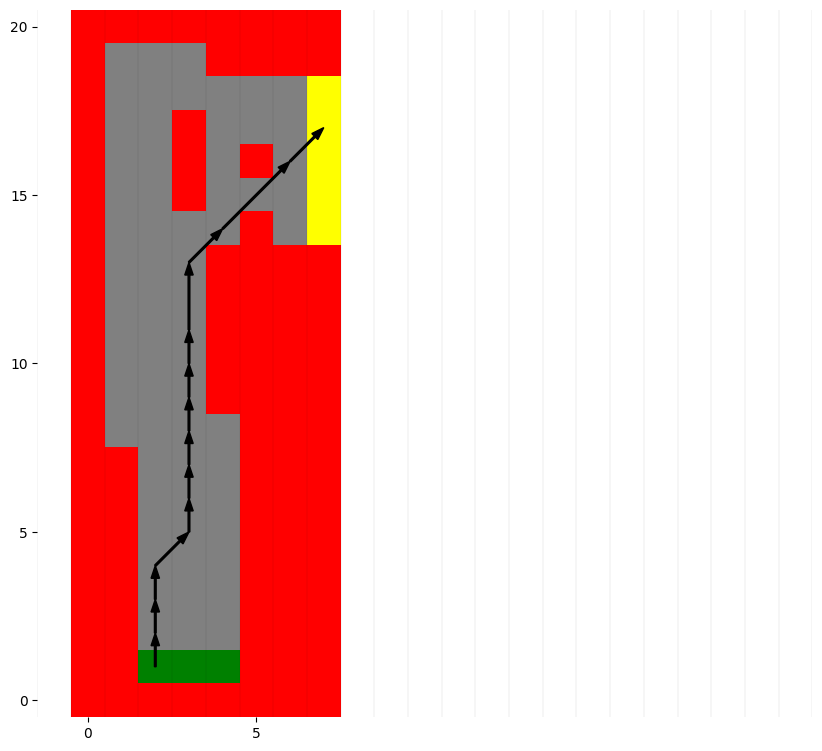

In [ ]:
vals = episode(policy=pi1,env=env,render=True)

In [ ]:
np.save("onPolicy",pi)
np.save("offPolicy",pi1)
np.save("target",tr)
np.save("q1",q1)
np.save("q",q)
np.save("x1",np.array(x1))
np.save("x",np.array(x))
np.save("qs",np.array(Qs))
np.save("qs1",np.array(Qs))

## Convergence Test

On policy Convergence

<AxesSubplot: >

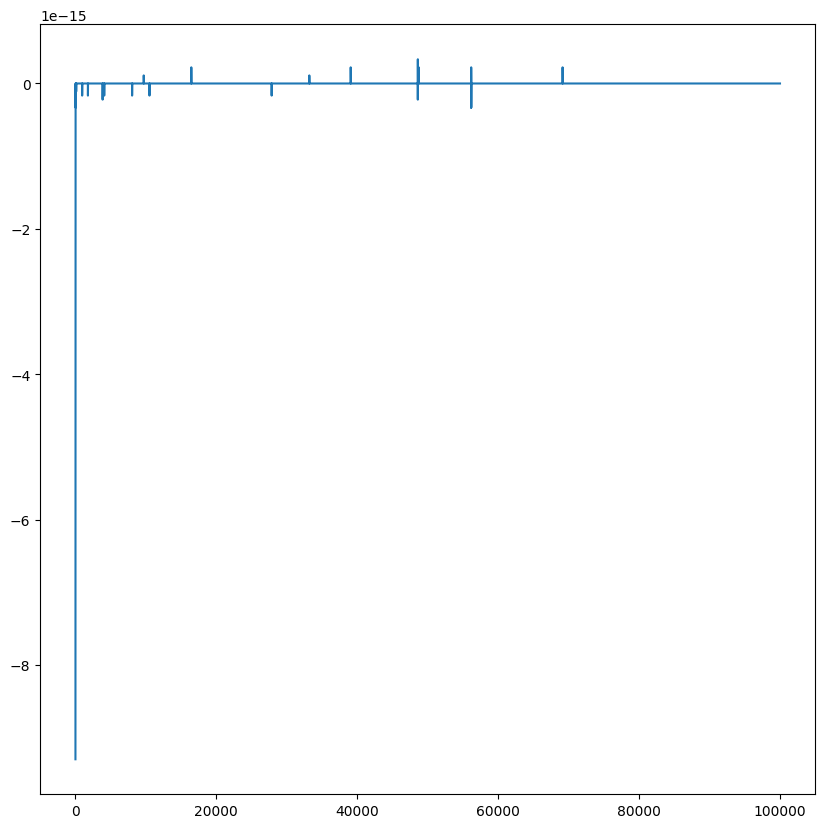

In [217]:
sns.lineplot(x = np.arange(len(Qs)),y = np.array(Qs))

Off Policy Convergence

<AxesSubplot: >

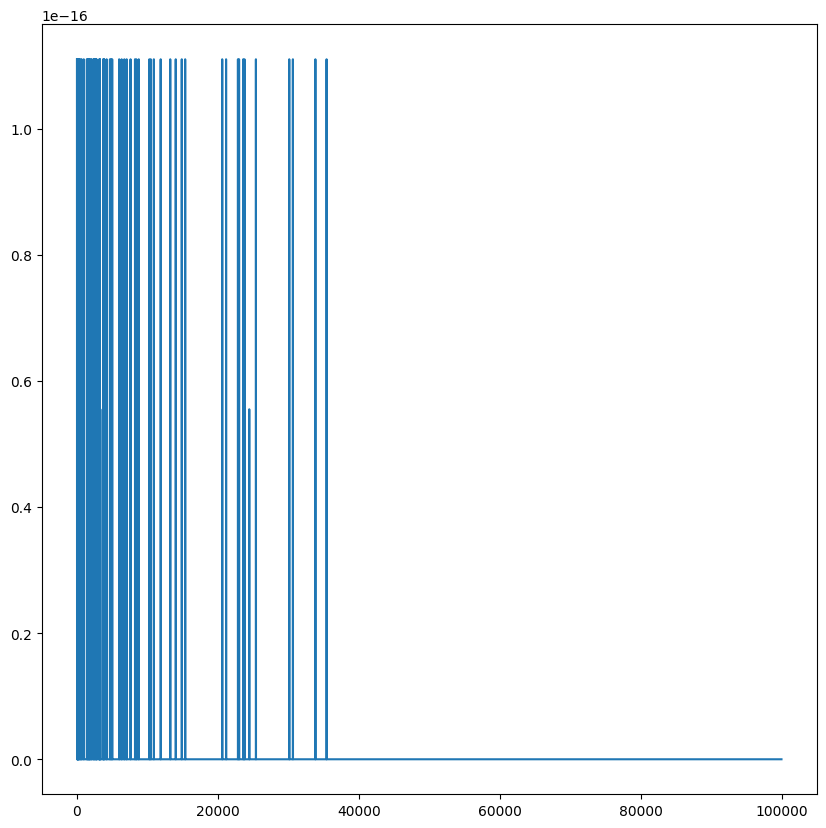

In [222]:
sns.lineplot(x = np.arange(len(Qs1)), y = np.array(Qs1))